# INTRODUCTION

This notebook looks into developing an end-to-end machine learning pipeline in Python to predict the probability of default (Credit risk modelling concept) using a financial dataset.

We're going to take the following approach:

- Problem definition
- Data
- Evaluation
- Features
- Modelling
- Experimentation

### Problem Definition

- Given Financial details about a person, can we predict whether or not they are likely to default on a loan?

### Evaluation

- If we can reach a considerable good roc-auc score in classification.


# Preparing the tools

We're going to use pandas, Matplotlib and NumPy for data analysis and manipulation.


In [244]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# we want our plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve




### Load Data


In [245]:
 
data = pd.read_csv('data_science_competition_2024.csv')
df = pd.read_csv('data_science_competition_2024.csv')
df.columns
print(df.shape )# (rows, columns)
df.head(4)


(100000, 21)


,Unnamed: 0,loan_id,gender,disbursemet_date,currency,country,sex,is_employed,job,location,...,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status
0,0,8d05de78-ff32-46b1-aeb5-b3190f9c158a,female,2022 10 29,USD,Zimbabwe,female,True,Teacher,Beitbridge,...,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default
1,1,368bf756-fcf2-4822-9612-f445d90b485b,other,2020 06 06,USD,Zimbabwe,other,True,Teacher,Harare,...,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default
2,2,6e3be39e-49b5-45b5-aab6-c6556de53c6f,other,2023 09 29,USD,Zimbabwe,other,True,Nurse,Gweru,...,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default
3,3,191c62f8-2211-49fe-ba91-43556b307871,female,2022 06 22,USD,Zimbabwe,female,True,Doctor,Rusape,...,0,35681.496413,0.23,47,0,42,2246.797020,divorced,47,Did not default


#### class balance


# PRIMARY DATA CLEANING

### Feature data type correction

In [246]:
df.dtypes
# remaining term contains both numerical and string values

Unnamed: 0                int64
loan_id                  object
gender                   object
disbursemet_date         object
currency                 object
country                  object
sex                      object
is_employed                bool
job                      object
location                 object
loan_amount             float64
number_of_defaults        int64
outstanding_balance     float64
interest_rate           float64
age                       int64
number_of_defaults.1      int64
remaining term           object
salary                  float64
marital_status           object
age.1                     int64
Loan Status              object
dtype: object

In [247]:
# function to correct spelling
def consistent_column_spelling(column, current_label, correctlabel):
    df.loc[df[column]== current_label, column] = correctlabel



In [248]:
#Convert remaining term feature to consitenly become numeric

# Convert to string to handle non-numeric characters
df['remaining term'] = df['remaining term'].astype(str)

# Remove underscores and extra spaces
df['remaining term'] = df['remaining term'].str.replace('_', '').str.strip()

# Convert back to numeric if all values are intended to be numeric
df['remaining term'] = pd.to_numeric(df['remaining term'], errors='coerce')


df['remaining term'].dtype

dtype('int64')

## Feature category spelling correction

In [249]:
print(df['location'].value_counts())
#incorrect spellings for locations


location
Harare               8338
Bulawayo             8078
Mutare               8062
Gweru                7803
Masvingo             7476
                     ... 
 Redcliff               1
Victoria Falls          1
Victoria Falls          1
   Gokwe                1
Gokwe                   1
Name: count, Length: 157, dtype: int64


In [250]:
#location feature textual normalization
df['location'] = df['location'].str.strip()

# convert lowercase
df['location'] = df['location'].str.lower()

# Create a dictionary to map incorrect variations to correct values
mapping = {
    'harare': 'Harare',
    'bulawayo': 'Bulawayo',
    'mutare': 'Mutare',
    'gweru': 'Gweru',
    'masvingo': 'Masvingo',
    'marondera': 'Marondera',
    'rusape': 'Rusape',
    'chivhu': 'Chivhu',
    'plumtree': 'Plumtree',
    'beitbridge': 'Beitbridge',
    'chipinge': 'Chipinge',
    'chimanimani': 'Chimanimani',
    'kwekwe': 'Kwekwe',
    'chiredzi': 'Chiredzi',
    'kadoma': 'Kadoma',
    'nyanga': 'Nyanga',
    'karoi': 'Karoi',
    'shurugwi': 'Shurugwi',
    'zvishavane': 'Zvishavane',
    'gokwe': 'Gokwe',
    'kariba': 'Kariba',
    'victoria falls': 'Victoria Falls',
    'redcliff': 'Redcliff',
    'hwange': 'Hwange'
}

# Replace incorrect values using the mapping dictionary
df['location'] = df['location'].replace(mapping)

# df = df.loc[~df.location.isin([ 'Redcliff']),: ]

print(df['location'].value_counts())
# the locations are now normalized


location
Harare            8553
Bulawayo          8263
Mutare            8262
Gweru             7983
Masvingo          7665
Marondera         7513
Rusape            6506
Chivhu            6411
Plumtree          5552
Beitbridge        5311
Chipinge          4447
Chimanimani       4388
Kwekwe            3491
Chiredzi          3199
Kadoma            3118
Nyanga            2142
Karoi             1899
Shurugwi          1359
Zvishavane        1301
Gokwe              920
Kariba             671
Victoria Falls     219
Redcliff           191
Hwange              41
Name: count, dtype: int64


In [251]:
print(df.currency.value_counts())
print()
print(df['country'].value_counts())
print()
print(df['job'].value_counts())
#Textual normalization required

df['Category'] = df['location'].apply(lambda x: 
                                     
                                     2 if x in [
    
    'Karoi',
    'Hwange',

    'Gokwe',
    
   
    'Shurugwi',
    'Victoria Falls',
    
    ] else 0 if x in ['Nyanga', 'Chivhu', 'Kadoma', 'Marondera', 'Gweru', 'Masvingo', 'Harare'] else 1 )

currency
USD     99980
$USD       20
Name: count, dtype: int64

country
Zimbabwe    99787
zimbabwe      100
Zim            13
Name: count, dtype: int64

job
Engineer              16524
Nurse                 15284
Data Analyst          13204
Doctor                12186
Software Developer    11932
Teacher                8950
Accountant             7802
SoftwareDeveloper      3564
Data Scientist         3521
Lawyer                 2862
Data Scintist            35
Name: count, dtype: int64


In [252]:
#correcting feature categories

def consistent_column_spelling(column, current_label, correctlabel):
    df.loc[df[column]== current_label, column] = correctlabel
    return df.loc[:, column].value_counts()

consistent_column_spelling('currency', '$USD', 'USD')
consistent_column_spelling('job', 'Data Scintist', 'Data Scientist')
consistent_column_spelling('job', 'SoftwareDeveloper', 'Software Developer')
consistent_column_spelling('country', 'Zimbabwe', 'zimbabwe')
consistent_column_spelling('country', 'Zim', 'zimbabwe')

print(df.currency.value_counts())
print()
print(df['country'].value_counts())
print()
print(df['job'].value_counts())

currency
USD    100000
Name: count, dtype: int64

country
zimbabwe    99900
Name: count, dtype: int64

job
Engineer              16524
Software Developer    15496
Nurse                 15284
Data Analyst          13204
Doctor                12186
Teacher                8950
Accountant             7802
Data Scientist         3556
Lawyer                 2862
Name: count, dtype: int64


Drop unnecessary and redundant columns

In [253]:


# Drop unnecessary columns
df.drop(['loan_id', 'Unnamed: 0', 'age.1', 'number_of_defaults.1', 'sex'], axis=1, inplace=True)




# EXPLORATORY DATA ANALYSIS

#### The goal here is to find out more about the data and become a subject matter expert.

1. What question(s) are you trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?


In [254]:
df.describe()

,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,Category
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,31120.000000,0.441970,36964.909763,0.210435,43.57069,52.881870,2781.804324,0.610530
std,15895.093631,0.688286,10014.758477,0.018725,4.86376,11.985833,696.450055,0.571442
min,1000.000000,0.000000,0.000000,0.100000,21.00000,0.000000,250.000000,0.000000
25%,21000.000000,0.000000,29625.227472,0.200000,40.00000,45.000000,2273.929349,0.000000
50%,31000.000000,0.000000,35063.852394,0.210000,44.00000,52.000000,2665.441567,1.000000
75%,40000.000000,1.000000,42133.388817,0.220000,47.00000,61.000000,3146.577655,1.000000
max,273000.000000,2.000000,150960.000000,0.300000,65.00000,120.000000,10000.000000,2.000000


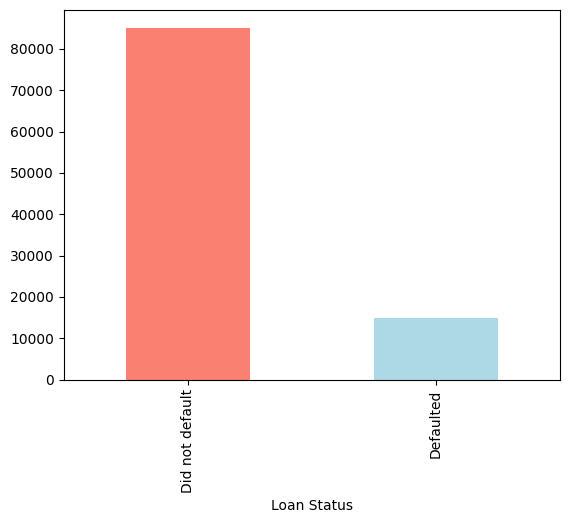

In [255]:

df['Loan Status'].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [256]:
print(df.shape)
print()
print(df.isna().sum())



(100000, 17)

gender                    0
disbursemet_date          0
currency                  0
country                 100
is_employed               0
job                    4136
location                595
loan_amount               0
number_of_defaults        0
outstanding_balance       0
interest_rate             0
age                       0
remaining term            0
salary                    0
marital_status            0
Loan Status               0
Category                  0
dtype: int64


## Structure overview 
* The dataset is has 100000 rows and 21 columns. 
* It has both categorical and numerical features.
* It is extremely imbalanced 
* It has missing values in the job, location and country columns

### Univariate relationships
* identify the distribution of the individual features

In [257]:
#univariate hist plots
# fig, (ax,ax1) = plt.subplots(2,3,figsize=(20,8))
# plt.suptitle('DISTRIBUTION PLOTS')
# sns.histplot(df,x= 'age', bins=100,kde=True, ax=ax[0], color='darkcyan');
# sns.histplot(df,x = 'interest_rate', bins=100,kde=True, ax=ax[1], color='salmon');
# sns.histplot(df, x = 'salary', bins=100,kde=True, ax=ax[2], color='darkviolet');
# sns.histplot(df, x = 'outstanding_balance', bins=100,kde=True, ax=ax1[0], color='yellow');
# sns.histplot(df, x = 'remaining term', bins=100,kde=True, ax=ax1[1], color='gold');
# sns.histplot(df, x = 'loan_amount', bins=100,kde=True, ax=ax1[2], color='darkgoldenrod');

# fig, ax = plt.subplots(1,4,figsize=(20,5))
# plt.suptitle('BOX PLOTS')
# sns.boxplot(df, x='loan_amount', ax=ax[0]);
# sns.boxplot(df, x='age', ax=ax[1]);
# sns.boxplot(df, x='outstanding_balance', ax=ax[2]);
# sns.boxplot(df, x='salary', ax=ax[3]);


#### OBSERVATIONS
* age, interest rate are uniformly distributed.
* outstanding balance, loan amount, salary and outstanding balance are skewed.
* Loan amount has a sharp peak at the start.
* outstanding balance and salary have considerable outliers.

#### Further investigate the sharp peak on loan amount distribution

In [258]:
# pd.set_option('display.max_colwidth', None)
# # print(df['remaining term'].value_counts().to_string())
# df[['loan_amount', 'outstanding_balance', 'remaining term', 'salary', 'age', 'interest_rate']].groupby((pd.cut(df['remaining term'], bins=np.arange(0, 150, 10)))).size()

In [259]:
# plt.figure(figsize=(10, 6))
# sns.histplot(df[df['loan_amount']<100000]['loan_amount'], kde=True)
# plt.title('Distribution of Loan Amounts below 10000')
# plt.show()

* There is indeed a sharp peak at around $5000. Indicates a high number of points there.


### TEST IF THE THESE NUMERICAL FEATURES ARE NORMALLY DISTRIBUTED USING QQPLOT

In [260]:
# import statsmodels.graphics.gofplots as sm

# plt.figure(figsize = (20,16))

# fig, ((ax, ax1), (ax2,ax3), (ax4,ax5)) = plt.subplots(nrows=3, ncols=2, figsize = (15,12))
       
# sm.qqplot(df['interest_rate'], line='s', ax=ax)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax.set_ylabel('interest rates Quantiles')

# sm.qqplot(df['salary'], line='s', ax=ax1)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax1.set_ylabel('salary Quantiles')

# sm.qqplot(df['age'], line='s', ax=ax2)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax2.set_ylabel('age Quantiles')

# sm.qqplot(df['loan_amount'], line='s', ax=ax3)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax3.set_ylabel('loan amount Quantiles')

# sm.qqplot(df['remaining term'], line='s', ax=ax4)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax4.set_ylabel('remaining term Quantiles')
# sm.qqplot(df['outstanding_balance'], line='s', ax=ax5)  # 's' for straight reference line
# plt.xlabel('Theoretical Quantiles')
# ax5.set_ylabel('outstanding balance Quantiles')
       


LOAN AMOUNT AND SALARY AND OUTSTANDING BALANCE ARE  HIGHLY DEVIATING AWAY FROM NORMAL DISTRIBUTION

## CATEGORICAL FEATURE DISTRIBUTION

## bivariate relationships


In [261]:
# fig, (ax, ax1, ax2) = plt.subplots(3,2,figsize=(15,18))

# sns.countplot(df,x= 'gender', ax=ax[0], palette='magma', hue='Loan Status');
# sns.countplot(df,x= 'marital_status', ax=ax[1], palette='spring', hue='Loan Status');
# sns.countplot(df,x= 'number_of_defaults', ax=ax1[0], palette='rocket', hue='Loan Status');
# sns.countplot(df,x= 'job', ax=ax1[1], palette='crest', hue='Loan Status');
# sns.countplot(df,x= 'location', ax=ax2[0], palette='mako', hue='Loan Status', );
# sns.countplot(df,x= 'is_employed', ax=ax2[1], palette='cividis', hue='Loan Status', );
# ax2[0].set_xticks(ax2[0].get_xticks());
# ax1[1].set_xticks(ax1[1].get_xticks());
# ax2[0].set_xticklabels(ax2[0].get_xticklabels(), rotation=45, ha='right');
# ax1[1].set_xticklabels(ax1[1].get_xticklabels(), rotation=45, ha='right');
# plt.subplots_adjust(hspace=0.4)

###    OBSERVATIONS
* Towns like Chiredzi, Shurugwi, Gokwe, Karoi, Hwange and Kwekwe have high probability of defaulting
* Cities like Harare, Bulawayo, 'Mutare', 'Gweru have low probability of Default'
* People who are married are less likely to deafulted
* People with less previous defaults are less likely to deasex is roughly balanced
* There is an additional unlabeled marital status category
* Lawyers and Accountants have high probability of defaulting

In [262]:

# # Create another figure
# plt.figure(figsize=(10, 6))
# fig, ((ax, ax1), (ax2,ax3), (ax4, ax5),(ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize = (15,12))

# sns.scatterplot(data=df, x='age', y= 'interest_rate', hue= 'Loan Status', ax= ax);
# sns.scatterplot(data=df, x='age', y= 'loan_amount', hue= 'Loan Status', ax= ax1);
# sns.scatterplot(data=df, x='age', y= 'outstanding_balance', hue= 'Loan Status', ax= ax2);
# sns.scatterplot(data=df, x='age', y= 'salary', hue= 'Loan Status', ax= ax3);
# sns.scatterplot(data=df, x='salary', y= 'loan_amount', hue= 'Loan Status', ax= ax4);
# sns.scatterplot(data=df, x='salary', y= 'interest_rate', hue= 'Loan Status', ax= ax5);
# sns.scatterplot(data=df, x='interest_rate', y= 'outstanding_balance', hue= 'Loan Status', ax= ax6);
# sns.scatterplot(data=df, x='loan_amount', y= 'outstanding_balance', hue= 'Loan Status', ax= ax7);
# # from sklearn.cluster import KMeans
# # from sklearn.decomposition import PCA

# # pca = PCA(n_components=2,whiten= True).fit_transform(df[['age', 'interest_rate']])
# # plt.scatter(pca.T[0], pca.T[1], c=np.where(df['Loan Status']== 'Did not default', 'red','blue'))

In [263]:
# fig, (ax, ax1, ax2, ax3, ax4,ax5) = plt.subplots(6,2,figsize=(30,30))
# plt.suptitle('BIVARIATE ANALYSIS (HUE=LOAN STATUS)', fontsize=20)
# plt.tight_layout(2)

# sns.lineplot(data=df, x='age', y='loan_amount', hue='Loan Status', lw=2, ax=ax[0]);
# sns.lineplot(data=df, x='interest_rate', y='loan_amount', hue='Loan Status', lw=2, ax=ax[1]);
# sns.lineplot(data=df, x='age', y='salary', hue='Loan Status', lw=2, ax=ax1[0]);
# sns.lineplot(data=df, x='interest_rate', y='age', hue='Loan Status', lw=2, ax=ax1[1]);
# sns.lineplot(data=df, x='interest_rate', y='remaining term', hue='Loan Status', lw=2, ax=ax2[0]);
# sns.lineplot(data=df, x='age', y='remaining term', hue='Loan Status', lw=2, ax=ax2[1]);
# sns.lineplot(data=df, x='age', y='loan_amount', hue='Loan Status', lw=2, ax=ax3[0]);
# sns.lineplot(data=df, x='interest_rate', y='salary', hue='Loan Status', lw=2, ax=ax3[1]);
# sns.lineplot(data=df, x='age', y='salary', hue='Loan Status', lw=2, ax=ax4[0]);
# sns.lineplot(data=df, x='loan_amount', y='salary', hue='Loan Status', lw=2, ax=ax4[1]);
# sns.lineplot(data=df, x='remaining term', y='salary', hue='Loan Status', lw=2, ax=ax5[0]);
# sns.lineplot(data=df, x='remaining term', y='loan_amount', hue='Loan Status', lw=2, ax=ax5[1]);

### OBSERVATIONS
1. The age vs loan_amount seems to be to seperate classes well in the first half
2. The interest rate vs loan_amount seems to be to seperate classes well in the forst 3 quarter.
3. Age is also a good seperater with salary.
4. Remaining term is also good in the last quarter.

#### multivariate relationships


<Axes: >

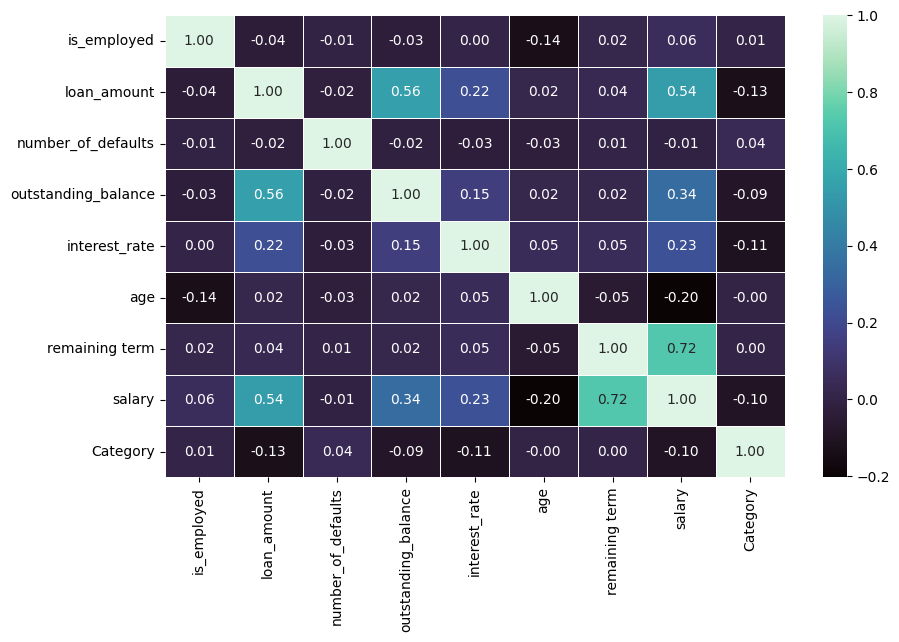

In [264]:
corrData = df.loc[:, [col for col in df if df[col].dtype not in ['category', 'object']]]
plt.figure(figsize=(10,6))
sns.heatmap(corrData.corr(), annot= True, linewidths=0.5,
                 fmt=".2f",
                 cmap="mako")


### THE SEEMS TO BE SOME TIGHT CORRELATION BETWEEN SOME FEATURES
`salary` and `loan amount`,  
`salary` and `loan remaining term`, 
`loan amount` and `outstanding_balance`

# SECONDARY DATA HANDLING
## HANDLING MISSING VALUES 

In [265]:
df.isna().sum()

gender                    0
disbursemet_date          0
currency                  0
country                 100
is_employed               0
job                    4136
location                595
loan_amount               0
number_of_defaults        0
outstanding_balance       0
interest_rate             0
age                       0
remaining term            0
salary                    0
marital_status            0
Loan Status               0
Category                  0
dtype: int64

In [266]:
# df.loc[(df.job.isna())& (df.loan_amount>60000), 'job'] = 'Data Scientist'
# fill job with mode job Engineer
df.job.fillna('Engineer',inplace= True)
df.location.fillna(df['location'].mode()[0],inplace= True)
df.isna().sum()

C:\Users\Augah\AppData\Local\Temp\ipykernel_11664\1071435340.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.job.fillna('Engineer',inplace= True)
C:\Users\Augah\AppData\Local\Temp\ipykernel_11664\1071435340.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

gender                   0
disbursemet_date         0
currency                 0
country                100
is_employed              0
job                      0
location                 0
loan_amount              0
number_of_defaults       0
outstanding_balance      0
interest_rate            0
age                      0
remaining term           0
salary                   0
marital_status           0
Loan Status              0
Category                 0
dtype: int64

## EARLIER
* Earlier we discovered that the marital status feature has a category called " " white space.
* We want to predict this category into its corresponding valid category using the XGB MODEL.
* We are going to use the custom made predict feature class.

In [267]:

print(df['marital_status'].value_counts())


marital_status
married     44710
divorced    26465
single      25698
             3127
Name: count, dtype: int64


## DATA PREPROCESSING

In [268]:
# convert the disbursement date to right date and time format.
import pandas as pd

# Save disbursement before dropping for use in feature engineering 
disbursement_date = df['disbursemet_date']

# Convert 'disbursemet_date' to datetime format
df['disbursemet_date'] = pd.to_datetime(df['disbursemet_date'], format='%Y %m %d')

In [269]:
# encode categorical variables

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

categorical_features = ['gender', 'job', 'location', 'currency', 'country']

for i, cat in enumerate(categorical_features):
    df[cat] = le.fit_transform(df[cat])
le.fit([ 'Defaulted','Did not default'])
if df['Loan Status'].dtype != 'int64':
    df['Loan Status'] = df['Loan Status'].map({'Did not default': 0, 'Defaulted': 1}).astype('int')
df.head()



,gender,disbursemet_date,currency,country,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status,Loan Status,Category
0,0,2022-10-29,0,0,True,8,0,39000.0,0,48653.011473,0.22,37,47,3230.038869,married,0,1
1,2,2020-06-06,0,0,True,8,8,27000.0,2,28752.062237,0.20,43,62,3194.139103,single,0,0
2,2,2023-09-29,0,0,True,6,7,35000.0,1,44797.554126,0.22,43,57,3330.826656,married,0,0
3,0,2022-06-22,0,0,True,3,20,24000.0,0,35681.496413,0.23,47,42,2246.797020,divorced,0,1
4,1,2023-02-08,0,0,True,6,3,19000.0,0,34156.055882,0.20,42,45,2310.858441,married,0,1


## EARLIER
* Earlier we discovered that the marital status feature has a category called " " white space.
* We want to predict this category into its corresponding valid category using an XGB MODEL.
* We are going to use the custom made predict feature class.

In [270]:
import importlib
import predict_feature
importlib.reload(predict_feature)
from predict_feature import Predict_Marital
import xgboost as xgb





mdl = Predict_Marital(df.drop('disbursemet_date', axis =1))
mdl.train()

preds, feature_importances = mdl.predict()

df.loc[df.marital_status  == ' ', 'marital_status']

df.loc[df.marital_status  == ' ', 'marital_status'] =pd.DataFrame(preds)[0].map({0:'single', 1:'married', 2:'divorced'}).to_numpy()
df['marital_status'] = df['marital_status'].map({'single':0, 'married':1, 'divorced': 2}).astype('int')

print(df.marital_status.value_counts())


score: 0.9024516129032258
marital_status
1    46202
2    27288
0    26510
Name: count, dtype: int64


In [271]:
# DATA SEPERATION
X = df.drop(['Loan Status', 'disbursemet_date'], axis=1)
y = df['Loan Status']

# FEATURE SELECTION

 CHECKING FOR ASSOCIATION BETWEEN  CATEGORICAL VARIABLES USING CHI SQUARE AND P_VALUE


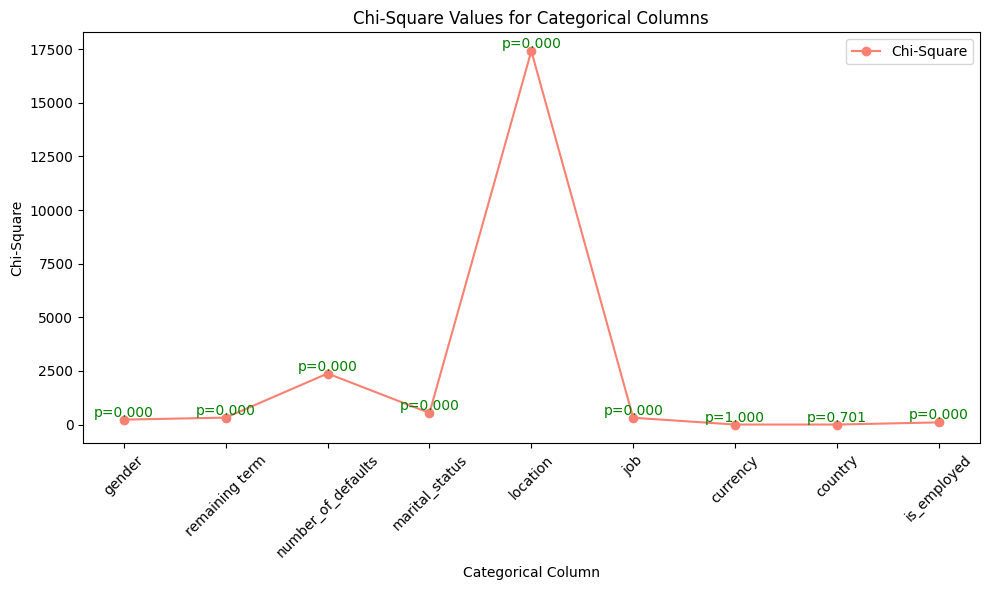

In [272]:
from scipy.stats import chi2_contingency

out = {'chi': [], 'p_value': [], 'col': []}

for i in ['gender', 'remaining term', 'number_of_defaults', 'marital_status', 'location', 'job', 'currency', 'country', 'is_employed']:
    observed_data = pd.crosstab(X[i], df['Loan Status']).to_numpy()

    chi2_statistic, pval, expected_frequency, obs = chi2_contingency(observed_data)

    out['chi'].append(chi2_statistic)
    out['p_value'].append(pval)
    out['col'].append(i)

# Create a DataFrame for chi-square values and p-values
chi_df = pd.DataFrame(out)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(chi_df['col'], chi_df['chi'], marker='o', color='salmon', label='Chi-Square')

# Adding p-values as text on the plot
for i, (col, chi, pval) in enumerate(zip(chi_df['col'], chi_df['chi'], chi_df['p_value'])):
    ax.text(i, chi, f'p={pval:.3f}', ha='center', va='bottom', color='green', fontsize=10)

# Adding labels and title
ax.set_xlabel('Categorical Column')
ax.set_ylabel('Chi-Square')
ax.set_title('Chi-Square Values for Categorical Columns')
ax.legend()

plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees for better readability
plt.tight_layout()
plt.show()
 

* currency and country have a p value of greater than 0.05 indicating no significance with target variable.
* Location has a very high chi coefficient indicating strong significance.

#### USING VARIANCE THRESHOLDS TO SELECT FEATURES

In [273]:
from sklearn.feature_selection import  VarianceThreshold
from sklearn.linear_model import LassoCV

selector = VarianceThreshold(threshold=0.04)
X_high_variance = selector.fit_transform(X)
X.columns[~X.columns.isin(selector.get_feature_names_out())]



Index(['currency', 'country', 'is_employed', 'interest_rate'], dtype='object')

#### USING RANDOM FOREST TO SELECT FEATURES

In [274]:
# model = RandomForestClassifier(n_estimators=100)
# rfe = RFE(model, n_features_to_select=10)
# fit = rfe.fit(X, y)
# selected_features_rfe = X.columns[~fit.support_]
# selected_features_rfe

* `currency` and `country` are in every selection method and should be removed.

In [275]:
X.drop(columns=[ 'country', 'currency'], inplace= True)

# PREDICTIVE MODELLING
## MODEL SELECTION
We are going to try the following algorithms with cross validation
1. Catboost
2. XGBOOST
3. RandomForestClassier
4. KNearest Neighbours
5. Logistic Regression
6. Decision Tress
7. LightGBM
### BASE MODEL

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11893, number of negative: 68107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148663 -> initscore=-1.745130
[LightGBM] [Info] Start training from score -1.745130
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11893, number of negative: 68107
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info]

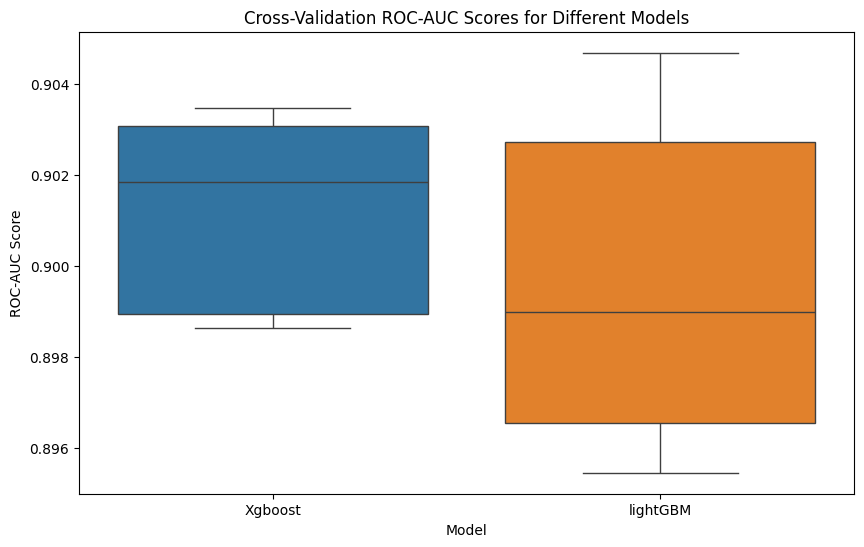

{'Xgboost': 0.9011811579986018, 'lightGBM': 0.8996745084136396}


In [276]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold
from lightgbm import LGBMClassifier
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fitted_models = []
def cross_val(X, y, show_plots= True):

    models = {
        # 'Logistic Regression': LogisticRegression(max_iter=1000),
        # 'Decision Tree': DecisionTreeClassifier(),
        # 'Random Forest': RandomForestClassifier(),
        'Xgboost': XGBClassifier(),
        # 'Catboost': CatBoostClassifier(),
        # 'Knn': KNeighborsClassifier(),
        'lightGBM':LGBMClassifier()
    }
    mean_scores = {}
    cv_results = {}

    for name, model in models.items():
        cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='roc_auc');
        cv_results[name] = cv_scores
        mean_scores[name] = cv_scores.mean()
        fitted_models.append(model)

    cv_df = pd.DataFrame(cv_results)

    if show_plots == True:
        # Plotting
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=cv_df)
        plt.title('Cross-Validation ROC-AUC Scores for Different Models')
        plt.xlabel('Model')
        plt.ylabel('ROC-AUC Score')
        plt.show()
        print(mean_scores )  


    return mean_scores, cv_results  
cross_val(X, y);
  

Xgboost, Catboost, RandomForest and LightGBM roughly have the same same score

## FEATURE ENGINEERING

In [279]:
from sklearn.preprocessing import StandardScaler
# allot different loan_amount ranges

df['less_than_10000'] = np.where(df.loan_amount<10000,3,1)
df['greater_than_75000'] = np.where(df.loan_amount>75000,3,1)

location_ratios = df.groupby('location')['Loan Status'].mean()
location_ratios = location_ratios / (1 - location_ratios)

# Define a threshold for classification (example: 0.2)
threshold = 0.2

# Classify locations based on imbalance ratio
df['location_class'] = df['location'].map(lambda loc: 1 if location_ratios[loc] < threshold else 0)
job_ratios = df.groupby('job')['Loan Status'].mean()
job_ratios = job_ratios / (1 - job_ratios)

# Define a threshold for classification (example: 0.2)
threshold = 0.2

# Classify jobs based on imbalance ratio
df['job_class'] = df['job'].map(lambda loc: 1 if job_ratios[loc] < threshold else 0)

#crete location category column to split highly balanced and low balanced location
df['location_category'] = np.where(df['location'].isin([4,12,13,21,22,9]),1,0)
df['job_category'] = np.where(df['job'].isin([0,2,3,5]),1,0)
df['low_risk'] = np.where(df['interest_rate']>0.13,1,0)
df['low_'] = np.where((df['remaining term']>25) & (df['remaining term']<70),1,0)
df['low_'] = np.where((df['age']>28) & (df['age']<40),1,0)
# df = df[df.loan_amount<8000]




[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11893, number of negative: 68107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148663 -> initscore=-1.745130
[LightGBM] [Info] Start training from score -1.745130
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11893, number of negative: 68107
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info]

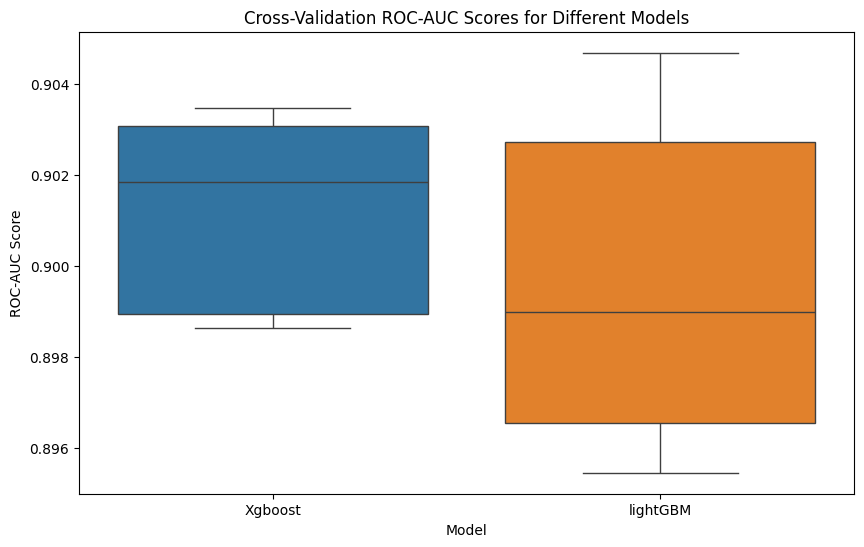

{'Xgboost': 0.9011811579986018, 'lightGBM': 0.8996745084136396}


In [280]:

# X_train, X_test, y_train, y_test,_,__ = split_data(df)
# from sklearn.preprocessing import StandardScaler
# # X_train= pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)
cross_val(X, y, show_plots=True);


* There is an increase in our cross validation scores.

## KMEANS CLUSTERING


#### APPLYING ELBOW METHOD TO FIND THE BEST NUMBER OF CLUSTERS

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# # num_df_scaled = scaler.fit_transform(df.drop('disbursemet_date', axis = 1))

# inertias = []

# for i in range(1,20):
#     kmeans = KMeans(n_clusters=i, random_state=0).fit(StandardScaler().fit_transform(df.drop(columns='Loan Status')))
#     inertias.append(kmeans.inertia_)


# plt.figure(figsize=(10,5))
# plt.title('ELBOW METHOD')
# plt.plot(np.arange(1,20),inertias, marker='o', lw=2, color='steelblue');


* There seem to be anomalies at k = 7. Lets investigate

In [ ]:
km = KMeans(n_clusters=8, random_state=0)
np.random.seed(76)
df['clusters'] = km.fit_predict(StandardScaler().fit_transform(df.drop(columns='Loan Status')))
# X_train, X_test, y_train, y_test,_,__ = split_data(df)
# from sklearn.preprocessing import StandardScaler
# # X_train= pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)
# cross_val(X_train, y_train)
# sns.countplot(df,x= 'clusters', palette='magma', hue='Loan Status');


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>)

In [ ]:
# df['low_2'] = np.where((df['clusters'].isin([4,7])),1,0)
# X_train, X_test, y_train, y_test,_,__ = split_data(df)
# from sklearn.preprocessing import StandardScaler
# # X_train= pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)
# cross_val(X_train, y_train)

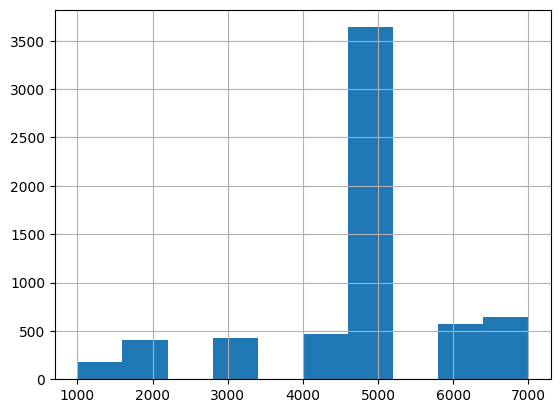

In [ ]:
df[df['loan_amount'] <8000]['loan_amount'].hist();

* Since there is a secondary distribution at loan amount = 5000
* Lets train a model on points with loan amount from 0 to 8000


In [ ]:
# X_train, X_test, y_train, y_test,_,__ = split_data(df[df['loan_amount']<=10000])

# cross_val(X_train, y_train)

In [ ]:
from sklearn.ensemble import IsolationForest

# iso = IsolationForest( contamination=0.05, n_jobs=-1, random_state=78)
# df['iso'] = iso.fit_predict(df.drop(['Loan Status'], axis =1))
# df1 = df
# X_train, X_test, y_train, y_test,_,__ = split_data(df[df['loan_amount']<10000])
# from sklearn.preprocessing import StandardScaler
# # X_train= pd.DataFrame(StandardScaler().fit_transform(X_train), columns=X_train.columns)
# cross_val(X_train, y_train)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

x = CatBoostClassifier()
X_train, X_test, y_train, y_test,_,__ = split_data(df)
x.fit(X_train, y_train)
preds = x.predict(X_test)
# confusion_matrix(y_test, preds)
print(roc_auc_score(y_test, preds))
# preds
preds = x.predict(X_test)


Learning rate set to 0.06692
0:	learn: 0.6339270	total: 218ms	remaining: 3m 38s
1:	learn: 0.5818359	total: 350ms	remaining: 2m 54s
2:	learn: 0.5371795	total: 415ms	remaining: 2m 17s
3:	learn: 0.4979110	total: 460ms	remaining: 1m 54s
4:	learn: 0.4650463	total: 503ms	remaining: 1m 40s
5:	learn: 0.4385794	total: 563ms	remaining: 1m 33s
6:	learn: 0.4160291	total: 617ms	remaining: 1m 27s
7:	learn: 0.3962124	total: 677ms	remaining: 1m 23s
8:	learn: 0.3804498	total: 726ms	remaining: 1m 19s
9:	learn: 0.3678489	total: 771ms	remaining: 1m 16s
10:	learn: 0.3563962	total: 827ms	remaining: 1m 14s
11:	learn: 0.3458110	total: 881ms	remaining: 1m 12s
12:	learn: 0.3360298	total: 938ms	remaining: 1m 11s
13:	learn: 0.3281010	total: 989ms	remaining: 1m 9s
14:	learn: 0.3220553	total: 1.03s	remaining: 1m 7s
15:	learn: 0.3158899	total: 1.07s	remaining: 1m 6s
16:	learn: 0.3108002	total: 1.12s	remaining: 1m 4s
17:	learn: 0.3065007	total: 1.16s	remaining: 1m 3s
18:	learn: 0.3025812	total: 1.21s	remaining: 1m 2s

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

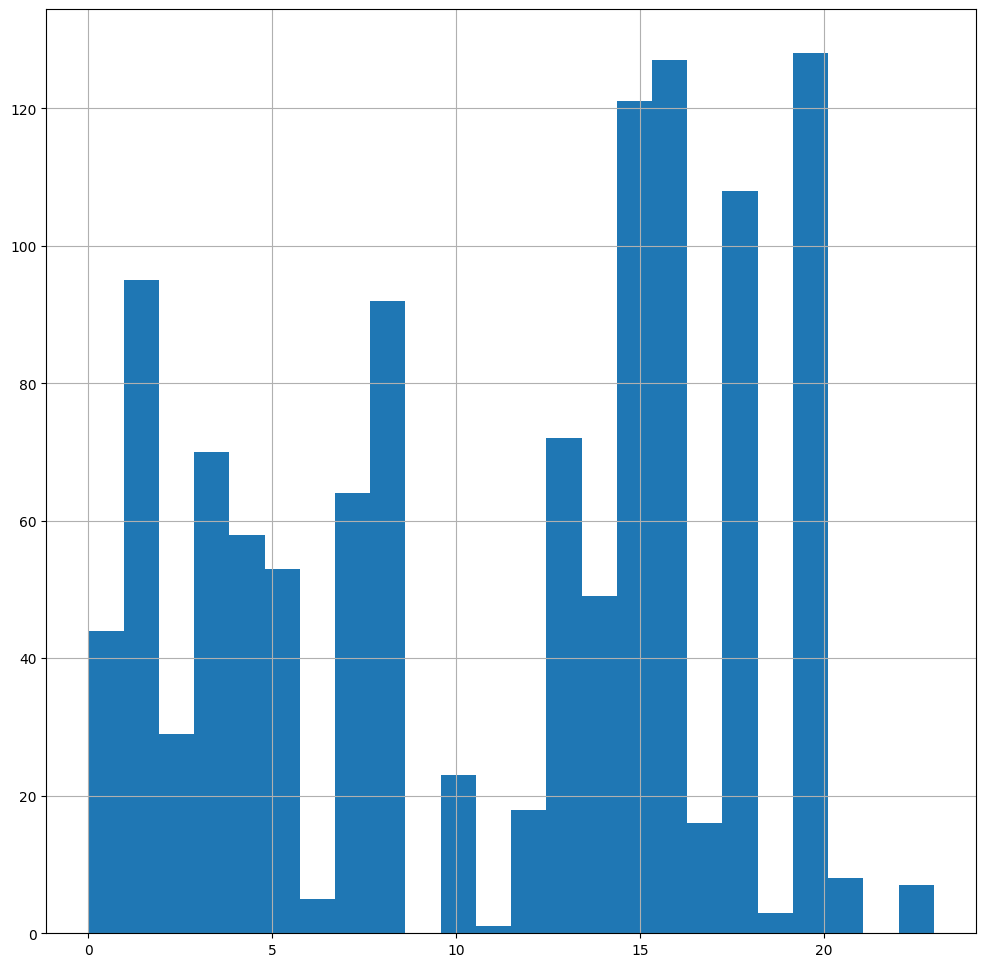

In [ ]:
X_test[(preds==0) & (y_test ==1) ]['location'].hist(figsize =(12,12) ,bins = 24);
# X_test[(preds==1) & (y_test ==1) ]['location'].hist(figsize =(12,12) ,bins = 30);

In [ ]:
f = pd.DataFrame(x.feature_importances_.T, index= x.feature_names_in_).sort_values(by=0, ascending= False)
# pd.DataFrame(x.feature_importances_)
f


AttributeError: 'LGBMClassifier' object has no attribute 'feature_names_in_'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert cv_results to DataFrame for easier plotting
cv_df = pd.DataFrame(cv_results)
   

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_df)
plt.title('Cross-Validation ROC-AUC Scores for Different Models')
plt.xlabel('Model')
plt.ylabel('ROC-AUC Score')
plt.show()
cv_scores = {}
for name, score in cv_results.items():
    cv_scores[name] = cv_results[name].mean()

cv_scores 
# cv_results

NameError: name 'cv_results' is not defined

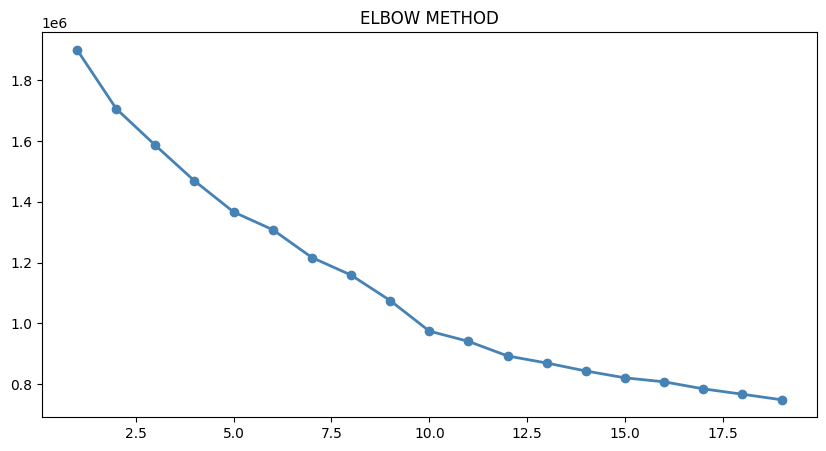

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# num_df_scaled = scaler.fit_transform(df.drop('disbursemet_date', axis = 1))

inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(StandardScaler().fit_transform(df.drop(columns='Loan Status')))
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(10,5))
plt.title('ELBOW METHOD')
plt.plot(np.arange(1,20),inertias, marker='o', lw=2, color='steelblue');

In [ ]:
# Fit the Isolation Forest model
from sklearn.ensemble import IsolationForest

X = df.drop(columns=['disbursemet_date', 'Loan Status'])
iso_forest = IsolationForest(contamination=0.007, random_state=42)
iso_forest.fit(X)
# Predict outliers
outlier_predictions = iso_forest.predict(X)

# Convert predictions to boolean: 1 for inliers, -1 for outliers
outliers = outlier_predictions == -1
inliers = outlier_predictions == 1

# Count the number of outliers
n_outliers = np.sum(outliers)
print(f'Number of outliers detected: {n_outliers}')
# Plot the inliers and outliers
# plt.figure(figsize=(8, 4))
# plt.scatter(X[inliers, 0], X[inliers, 1], color='blue', label='Inliers')
# plt.scatter(X[outliers, 0], X[outliers, 1], color='red', label='Outliers')
# plt.title('Isolation Forest Outlier Detection')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend()
# plt.show()

X[outliers]

Number of outliers detected: 700


,gender,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status,less_than_10000,greater_than_75000
526,0,False,4,13,15000.0,2,27190.199526,0.19,55,41,1965.265501,0,1,1
746,1,False,4,13,64000.0,2,51951.627974,0.21,33,74,5276.133661,2,1,1
762,2,True,0,8,5000.0,2,27598.920111,0.18,30,37,1912.883347,2,3,1
767,2,True,0,1,3000.0,2,25480.696201,0.20,32,70,2129.556834,2,3,1
1120,2,True,7,4,5000.0,1,26188.546327,0.14,31,46,2025.337473,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98702,0,True,0,2,7000.0,2,27003.037549,0.16,34,33,1865.689532,1,3,1
98765,0,True,0,3,5000.0,2,28204.239705,0.19,51,53,1984.638671,0,3,1
99123,2,True,7,1,7000.0,1,25625.507981,0.20,36,26,1778.299641,2,3,1
99743,2,True,5,11,5000.0,1,25335.967691,0.16,29,40,1967.850351,2,3,1


<Axes: >

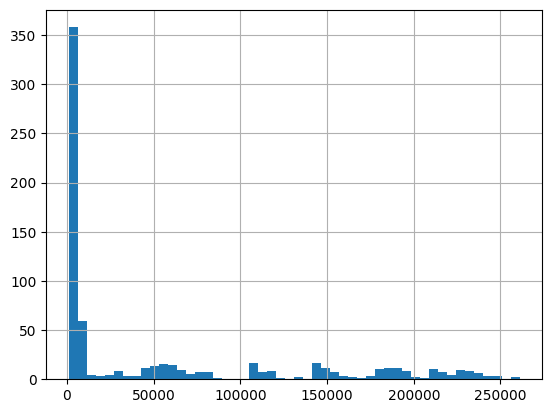

In [ ]:
df[outliers]['loan_amount'].hist(bins =50)

In [ ]:
from sklearn.metrics import silhouette_score


results = []

for i in range(2,3):
    for r in range(3):
        kmeans = KMeans(n_clusters=i, random_state=r)
        c_labels = kmeans.fit_predict(num_df_scaled)
        sil_ave = silhouette_score(num_df_scaled, c_labels)
        results.append([i, r, sil_ave])
        
res_df = pd.DataFrame(results, columns=['num_cluster', 'seed', 'sil_score'])
pivot_kmeans = pd.pivot_table(res_df, index='num_cluster', columns='seed', values='sil_score')

plt.figure(figsize=(15,6))
plt.tight_layout
sns.heatmap(pivot_kmeans, annot=True, linewidths=0.5, fmt='.3f', cmap='magma', annot_kws={"size":8});

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from datetime import datetime

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')  # Load your data

# Save disbursement before dropping for use in feature engineering 
disbursement_date = df['disbursemet_date']

# Convert 'disbursemet_date' to datetime format
df['disbursemet_date'] = pd.to_datetime(df['disbursemet_date'], format='%Y %m %d')

# Get today's date
today = pd.Timestamp.today()

# Calculate loan length in days
df['loan_length'] = (today - df['disbursemet_date']).dt.days


print(df[['disbursemet_date', 'loan_length']].head())


df['interest'] = (np.sqrt(df.loan_amount)* np.exp(df.interest_rate)* np.log(df['loan_length']))
df['u']=np.where((df.loan_amount)<df.outstanding_balance, 1.1,1)
df['t']=(np.sqrt(df['loan_length']/df['loan_amount'])/(df['interest_rate'])**3.3)

df['w'] = (df['remaining term'])**(1/3)/(df['interest_rate'])**4
df['u'] = (df['u'])/(df['interest_rate'])**5
df['y'] = df['Loan Status'].map({'Did not default': 0, 'Defaulted':1})
df['loan_type'] = pd.cut(df['loan_length'], bins= np.arange(0,1800, 400), labels= False)
df['remaining_bucket'] = (pd.cut(df['remaining term'], bins=np.arange(0,130,20), labels=False))
ome =df[['u','y','w' ,'interest_rate', 'age', 'interest', 't', 'loan_type', 'remaining_bucket' ]].corr()
# df[df['remaining_bucket']==0].hist(bins=50)
# sns.heatmap(ome, annot=True)
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['age', 'interest_rate']])

# Get feature names after polynomial transformation
# poly_feature_names = poly.get_feature_names(input_features=['age', 'interest_rate'])

# Create a DataFrame with polynomial features
df_poly = pd.DataFrame(poly_features)

# Concatenate the original DataFrame with the polynomial features
data = pd.concat([df, df_poly], axis=1)
data.tail(20)

# Now you can use 'data' DataFrame which includes both original and polynomial features




   disbursemet_date  loan_length
1        2020-06-06         1498
11       2022-02-11          883
18       2020-03-13         1583
19       2020-04-14         1551
20       2021-01-28         1262


,gender,disbursemet_date,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,...,u,t,w,y,loan_type,0,1,2,3,4
23395,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,36.0,0.22,1296.0,7.92,0.0484
23396,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,43.0,0.20,1849.0,8.60,0.0400
23397,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,45.0,0.21,2025.0,9.45,0.0441
23398,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,42.0,0.23,1764.0,9.66,0.0529
23399,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,47.0,0.23,2209.0,10.81,0.0529
23400,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,39.0,0.23,1521.0,8.97,0.0529
23401,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,29.0,0.24,841.0,6.96,0.0576
23402,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,34.0,0.21,1156.0,7.14,0.0441
23403,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,42.0,0.19,1764.0,7.98,0.0361
23404,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,43.0,0.17,1849.0,7.31,0.0289


In [ ]:
print(df.groupby('loan_type').median())

           gender disbursemet_date  is_employed  job  location  loan_amount  \
loan_type                                                                     
0.0           1.0       2023-09-22          1.0  4.0       8.0      32000.0   
1.0           1.0       2022-11-18          1.0  4.0       9.0      32000.0   
2.0           1.0       2021-10-18          1.0  4.0      10.0      31000.0   
3.0           1.0       2020-09-11          1.0  4.0      10.0      31000.0   

           number_of_defaults  outstanding_balance  interest_rate   age  ...  \
loan_type                                                                ...   
0.0                       0.0         35151.924131           0.21  43.0  ...   
1.0                       0.0         35287.423124           0.21  43.0  ...   
2.0                       0.0         35436.857345           0.21  43.0  ...   
3.0                       0.0         35275.998542           0.21  43.0  ...   

           Loan Status  loan_length  less_th

### Handle missing values


In [ ]:
df.isna().sum()

gender                     0
disbursemet_date           0
is_employed                0
job                        0
location                   0
loan_amount                0
number_of_defaults         0
outstanding_balance        0
interest_rate              0
age                        0
remaining term             0
salary                     0
marital_status             0
Loan Status                0
loan_length                0
less_than_10000            0
greater_than_75000         0
remaining_bucket           0
interest                   0
u                          0
t                          0
w                          0
y                      23416
loan_type                889
dtype: int64

In [ ]:
##drop location missing rows

df.dropna(subset=['country', 'location'], inplace=True)
df.isna().sum()

KeyError: ['country']

- too many missing location values so can't drop information.
- to predict a value of a column using random forest and impute the prediction on the missing slot.


In [ ]:
## to many values fitting a model to predict  
# df = df.loc[df.location!= 'Redcliff']
# print(df.location.value_counts())
# import importlib
# import predict_feature
# importlib.reload(predict_feature)
# from predict_feature import Predict_Job
# import xgboost as xgb





# mdl = Predict_Job(df)
# mdl.train()
df.dropna(axis=0)


,gender,disbursemet_date,currency,country,sex,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,number_of_defaults.1,remaining term,salary,marital_status,age.1,Loan Status,loan length
0,female,2022-10-29,USD,zimbabwe,female,True,Teacher,Beitbridge,39000.0,0,48653.011473,0.22,37,0,47,3230.038869,married,37,Did not default,52012800000000000
1,other,2020-06-06,USD,zimbabwe,other,True,Teacher,Harare,27000.0,2,28752.062237,0.20,43,2,62,3194.139103,single,43,Did not default,127612800000000000
2,other,2023-09-29,USD,zimbabwe,other,True,Nurse,Gweru,35000.0,1,44797.554126,0.22,43,1,57,3330.826656,married,43,Did not default,23068800000000000
4,male,2023-02-08,USD,zimbabwe,male,True,Nurse,Chipinge,19000.0,0,34156.055882,0.20,42,0,45,2310.858441,married,42,Did not default,43200000000000000
5,other,2020-11-15,USD,zimbabwe,other,True,Data Analyst,Chimanimani,29000.0,0,37778.075179,0.21,46,0,44,2633.653709,single,46,Did not default,113616000000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,male,2020-01-12,USD,zimbabwe,male,True,Teacher,Beitbridge,52000.0,0,44720.871567,0.21,41,0,33,2048.664042,married,41,Did not default,140227200000000000
99996,other,2023-06-11,USD,zimbabwe,other,True,Engineer,Chimanimani,43000.0,0,48652.554897,0.23,50,0,57,3056.127917,married,50,Did not default,32572800000000000
99997,female,2021-10-20,USD,zimbabwe,female,True,Data Analyst,Kadoma,48000.0,0,34266.224130,0.23,43,0,53,3535.599759,married,43,Did not default,84326400000000000
99998,male,2021-08-22,USD,zimbabwe,male,True,Engineer,Mutare,36000.0,2,71546.024917,0.22,49,2,59,3082.407123,single,49,Did not default,89424000000000000


In [ ]:

# import importlib
# import predict_feature
# importlib.reload(predict_feature)
# preds =mdl.predict()
# preds

In [ ]:
# # impute preds back into the dataset 
# # retaining mapping
# mapping = {0: 'Teacher', 1:'Nurse', 2:'Doctor', 3:'Data Analyst', 4:'Software Developer',
#        5:'Accountant',6: 'Lawyer',7: 'Engineer',8:'Data Scientist'}

# job = []

# for i in mdl.predict():
#     job.append(mapping[i])

# df.loc[df.job.isna(), 'job'] = job    

df.isna().sum()

gender                     0
disbursemet_date           0
currency                   0
country                    0
sex                        0
is_employed                0
job                     3292
location                   0
loan_amount                0
number_of_defaults         0
outstanding_balance        0
interest_rate              0
age                        0
number_of_defaults.1       0
remaining term             0
salary                     0
marital_status             0
age.1                      0
Loan Status                0
loan length                0
dtype: int64

# Modelling


### Split the data into training and sets by using train_test_split.


In [ ]:
# selected_rows = df[(df.age<40)& (df.interest_rate<0.16)].sample(n=40000, replace= True)
# elected_rows_duplicated = pd.concat([selected_rows] * 20, ignore_index=True)  # Duplicate 20 times
# augmented_data = pd.concat([df, selected_rows])

# # Reset index if needed
# augmented_data.reset_index(drop=True, inplace=True)
# df = augmented_data

# augmented_data['Loan Status'].value_counts()


In [ ]:
# Separate the data into labels and features

# Separate the y variable, the labels
y = df["Loan Status"].map({'Did not default':0, 'Defaulted':1})

# Separate the X variable, the features
X = df.drop(columns="Loan Status")
print(y.head(5))

# Check the balance of our target values
print(y.value_counts())
(X.head(3))


0    0
1    0
2    0
4    0
5    0
Name: Loan Status, dtype: int64
Loan Status
0    63297
1     9765
Name: count, dtype: int64


,gender,currency,country,is_employed,job,location,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status
0,female,USD,zimbabwe,True,Teacher,Beitbridge,39000.0,0,48653.011473,0.22,37,47,3230.038869,married
1,other,USD,zimbabwe,True,Teacher,Harare,27000.0,2,28752.062237,0.20,43,62,3194.139103,single
2,other,USD,zimbabwe,True,Nurse,Gweru,35000.0,1,44797.554126,0.22,43,57,3330.826656,married


## DATA PREPROCESSING


In [ ]:
import pandas as pd
from datetime import datetime

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')  # Load your data

# Save disbursement before dropping for use in feature engineering 
disbursement_date = df['disbursemet_date']

# Convert 'disbursemet_date' to datetime format
df['disbursemet_date'] = pd.to_datetime(df['disbursemet_date'], format='%Y %m %d')

# Get today's date
today = pd.Timestamp.today()

# Calculate loan length in days
df['loan_length'] = (today - df['disbursemet_date']).dt.days


print(df[['disbursemet_date', 'loan_length']].head())


  disbursemet_date  loan_length
0       2022-10-29          621
1       2020-06-06         1496
2       2023-09-29          286
3       2022-06-22          750
4       2023-02-08          519


In [ ]:
# Preprocess the data before initial training 
from sklearn.preprocessing import StandardScaler


#dummy encode categorical variables
X = pd.get_dummies(X, columns=['marital_status','gender' ,'job', 'location', 	'currency',	'country'])
X

# #convert column to datetime format
# X['disbursemet_date'] = pd.to_datetime(df['disbursemet_date'], format= '%Y %m %d')

# encode the target y variable
if y.dtype not in ['int64', 'int32']:
    y = y.map({'Did not default': 0, "Defaulted": 1}).astype('int')
y

X.head()



,is_employed,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status_,marital_status_married,...,location_Mutare,location_Nyanga,location_Plumtree,location_Redcliff,location_Rusape,location_Shurugwi,location_Victoria Falls,location_Zvishavane,currency_USD,country_zimbabwe
0,True,39000.0,0,48653.011473,0.22,37,47,3230.038869,False,True,...,False,False,False,False,False,False,False,False,True,True
1,True,27000.0,2,28752.062237,0.20,43,62,3194.139103,False,False,...,False,False,False,False,False,False,False,False,True,True
2,True,35000.0,1,44797.554126,0.22,43,57,3330.826656,False,True,...,False,False,False,False,False,False,False,False,True,True
4,True,19000.0,0,34156.055882,0.20,42,45,2310.858441,False,True,...,False,False,False,False,False,False,False,False,True,True
5,True,29000.0,0,37778.075179,0.21,46,44,2633.653709,False,False,...,False,False,False,False,False,False,False,False,True,True


## SPLITTING THE DATA TO HAVE A GLOBAL VALIDATION TEST SET


In [ ]:
# Import the train_test_learn module
from sklearn.model_selection import train_test_split

# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
feature_names = X_train.columns

In [ ]:
y_train.value_counts()

Loan Status
0    47472
1     7324
Name: count, dtype: int64

- #### Fit model. N.B, chose random forest due to its feature importance feature


In [ ]:
#fitting random forest to my model 
clf = RandomForestClassifier()
xgboost = xgb.XGBClassifier
clf.fit(X_train,y_train)


RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     15825
           1       0.89      0.53      0.66      2441

    accuracy                           0.93     18266
   macro avg       0.91      0.76      0.81     18266
weighted avg       0.93      0.93      0.92     18266

0.7596056053995949


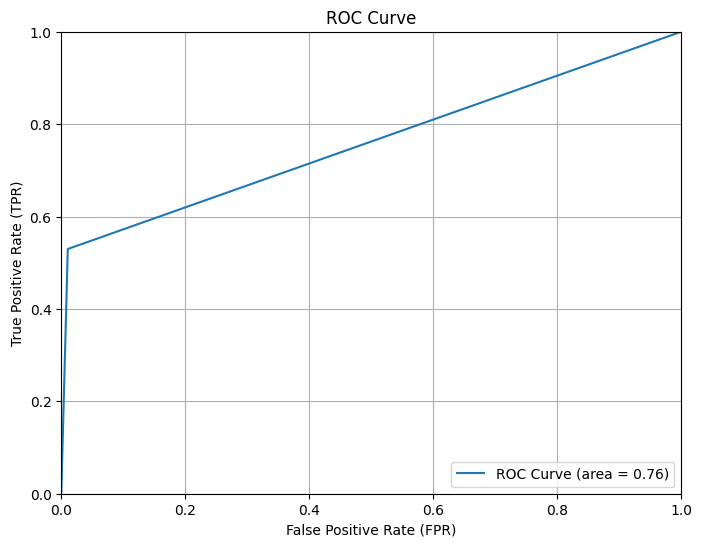

In [ ]:
#show metrics
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,confusion_matrix


def viewMetric(clf):
    y_preds = clf.predict(X_test)
    auc = roc_auc_score(y_test, y_preds)
    
    print(classification_report(y_test, y_preds))
    print(roc_auc_score(y_test, y_preds))

    # Calculate ROC curve (fpr, tpr, thresholds)
    fpr, tpr, thresholds = roc_curve(y_test, y_preds)

    # Calculate AUC score
    
    # sns.heatmap(confusion_matrix(y_preds, y_test), annot=True)
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % auc)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    

viewMetric(clf)



### Take the first columns whose feature importance sum is equal to 5%

### Remove the rest


In [ ]:
#sort and remove
feature_importances = pd.DataFrame(clf.feature_importances_).T
feature_importances.columns = clf.feature_names_in_
feature_importances = feature_importances.T.sort_values(by=0)

feature_importances.loc['loan length']


KeyError: 'loan length'

In [ ]:
# remove columns
X_train = X_train.drop(['country_zimbabwe', 'currency_USD', 'location_Kariba',
       'location_Zvishavane', 'location_Nyanga', 'location_Kadoma',
       'location_Hwange', 'location_Chimanimani', 'location_Beitbridge',
       'location_Chivhu', 'location_Marondera', 'location_Gweru',
       'marital_status_ ', 'location_Bulawayo', 'location_Harare', 'is_employed',
       'location_Mutare', 'location_Masvingo', 'location_Rusape'], axis = 1)
X_test = X_test.drop(['country_zimbabwe', 'currency_USD', 'location_Kariba',
       'location_Zvishavane', 'location_Nyanga', 'location_Kadoma',
       'location_Hwange', 'location_Chimanimani', 'location_Beitbridge',
       'location_Chivhu', 'location_Marondera', 'location_Gweru',
       'marital_status_ ', 'location_Bulawayo', 'location_Harare',
       'location_Mutare', 'location_Masvingo', 'location_Rusape', 'is_employed'], axis = 1)


We'll train it (find the patterns) on the training set.

And we'll test it (use the patterns) on the test set.

We're going to try 5 different machine learning models:

1. Logistic Regression
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier
4. Xgboost
5. Multi-layer-perceptron


In [ ]:
# #train on different models

# from sklearn.neighbors import KNeighborsClassifier
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.datasets import make_classification
# import matplotlib.pyplot as plt
# from sklearn.model_selection import cross_val_score


# xgboost = xgb.XGBClassifier()
# logistic = LogisticRegression(max_iter=1000)
# clf = RandomForestClassifier()
# KNN = KNeighborsClassifier()
# roc_auc_dict = {}
# threshold = 0.2
# scaler =StandardScaler()


# def model_train(X_train,y_train, scaler = scaler):
#   #model dictionary
#   models = [
#       {"name": 'RF', "estimator": clf },
#             {"name":"logistic" , "estimator": logistic },
#             {"name":"KNN" , "estimator": KNN },
#               {"name":"xgboost" , "estimator": xgboost }
#             ]

  
 
#   for model in models: 
      
#       model['estimator'].fit((X_train), y_train)
#       y_prob = model['estimator'].predict_proba((X_test))[:, 1]
#       preds = (y_prob > threshold).astype(int)
#       # print(roc_auc_score(y_test, preds))
#       preds
      
#       roc_auc_dict[model['name']] = roc_auc_score(y_test, preds)
  


  



#   # Build the neural network model for binary classification
#   model = Sequential([
#       Dense(64, input_shape=(X_train.shape[1],), activation='relu'),  # First hidden layer
#       Dense(32, activation='relu'),  # Second hidden layer
#       Dense(1, activation='sigmoid')  # Output layer for binary classification
#   ])

#   # Compile the model
#   model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


#   # Train the model
#   history = model.fit(scaler.fit_transform(X_train), y_train, epochs=5, batch_size=8, validation_split=0.2)


#   # Make predictions
#   y_pred_prob = model.predict(X_test)

#   # Convert probabilities to binary predictions
#   y_pred = (y_pred_prob > 0.2).astype(int)
#   roc_auc_dict['nueral network mlp'] = roc_auc_score(y_test,y_pred)
#   print(roc_auc_dict)


#   return pd.DataFrame(roc_auc_dict, index = ['roc_auc_score']).T.plot.bar()

# model_train(X_train, y_train,scaler= scaler)






## ROC_AUC SCORES WITH CROSS VALIDATION


(54796, 30) (54796,)


{'accuracy_score': [0.90360603190525], 'recall_score': [0.6717644864693485], 'precision_score': [0.631089111557083], 'f1_score': [0.650739546311722], 'roc_auc_score': [0.8055696464814022]}


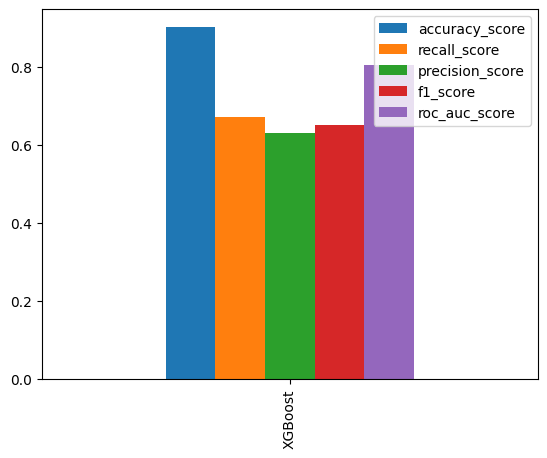

In [ ]:
import numpy as np
import pandas as pd
# from sklearn.base import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, make_scorer
# import xgboost as xgb
import statistics
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# cross val score with threshold function 
def cross_val_with_threshold(estimator, X ,y, metric,threshold, cv=5, ):

        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
        auc_scores = []
        

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            estimator.fit(X_train, y_train)
            probas = estimator.predict_proba(X_test)[:, 1]
            # probas = np.where(X_test['low_risk'] == 1, probas + 0.03, probas)

            np.where

            preds = (probas >= threshold).astype(int)
            auc_scores.append(metric(y_test, preds))
         
        


    
        return statistics.mean(auc_scores)

models = [
    # {"name": 'Random Forest', "estimator": RandomForestClassifier(n_estimators=100, random_state=42)},
    # {"name": "Logistic Regression", "estimator": LogisticRegression(max_iter=1000, random_state=42)},
    # {"name": "KNN", "estimator": KNeighborsClassifier()},
    {"name": "XGBoost", "estimator": xgb.XGBClassifier()},
    # {"name": "lda", "estimator": LinearDiscriminantAnalysis()}
]

def cross_val_scores(threshold, X,y):
    
    
    
    scores_dict = {}
    for metric in [accuracy_score, recall_score, precision_score, f1_score, roc_auc_score]:
        metric_values = []
        for model in models:
         
        
            metric_score = cross_val_with_threshold(model['estimator'], X, y,metric, cv= 5, threshold=threshold, )
            metric_values.append(metric_score)
        metric_name = metric.__name__
        scores_dict[metric_name] = metric_values
    return scores_dict   
        

# Define models
print(X_train.shape, y_train.shape)

score_dict = cross_val_scores( X=X_train, y=y_train,threshold=0.2, )
print(score_dict)
pd.DataFrame(score_dict, index=[model['name'] for model in models]).plot.bar()
plt.show()


## Chosen Model: XGBoost
#### Explanation
* Our data has very informative outliers so  its unwise to remove or transform them. 
   The best is to  leave them
* It is generally giving the best mark among all tried models

#### Assumptions: 
* Assumes that features are informative and not highly correlated to avoid overfitting.
#### Limitations:
* Can be sensitive to noisy data and requires careful tuning of hyperparameters.

# FEATURE ENGINEERING


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

#take the kmeans component as a column
kM = KMeans(n_clusters=2)
kmeans = kM.fit(X_train, y_train)
kmeans = kM.transform(X_train)
kmeans1 = kM.transform(X_test)
pca = PCA(n_components=1).fit_transform(X_test[['interest_rate', 'age']])


#age and interset rate on the plot seperates classes, create a new feature from them

X_train['rate_age_ratio'] = (X_train['interest_rate'] * X_train['age'])**4
X_test['rate_age_ratio'] = (X_test['interest_rate'] * X_test['age'])**4

X_train['K1'] = kmeans.T[0]
X_train['predicted_low_default'] = np.where((X_train['age'] < 40) & (X_train['interest_rate'] < 0.17), 1, 0)


X_test['K1'] = kmeans1.T[0]
X_test['predicted_low_default'] = np.where((X_test['age'] < 40) & (X_test['interest_rate'] < 0.17), 1, 0)

#add new feature. date to income ratio
X['debt_to_income'] = df['outstanding_balance']/df['salary']




## DATA SAMPLING TO BALANCE CLASSES


In [ ]:

# USING SMOTE TO RESAMPLE TO OUR DATA 

# from imblearn.over_sampling import ADASYN
# sm = ADASYN(sampling_strategy=0.3,random_state=42)
# X_resampled, y_resampled = sm.fit_resample(X_train,y_train)
# y_resampled.value_counts()

from imblearn.under_sampling import RandomUnderSampler
# # y = y.map({'Did not default': 0, 'Defaulted': 1}).astype('int')
# # Load your data (X: features, y: target labels)


# Define the under-sampler
rus = RandomUnderSampler(sampling_strategy='majority')  # Undersample majority class

# Resample the data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
X_resampled







,loan_amount,number_of_defaults,outstanding_balance,interest_rate,age,remaining term,salary,marital_status_married,marital_status_single,gender_female,...,location_Gokwe,location_Karoi,location_Kwekwe,location_Plumtree,location_Redcliff,location_Shurugwi,location_Victoria Falls,rate_age_ratio,K1,predicted_low_default
64348,18000.0,0,24722.823791,0.20,42,42,2210.779103,True,False,False,...,False,False,False,False,False,False,False,4978.713600,31035.662788,0
9230,38000.0,1,38243.852890,0.21,43,61,3446.503040,True,False,True,...,False,False,False,False,False,False,False,6648.918373,7008.788834,0
72016,46000.0,0,34919.989358,0.23,38,55,3758.769987,True,False,False,...,False,False,False,False,False,False,False,5835.065434,8931.869902,0
13903,22000.0,0,31607.269037,0.21,55,56,2349.600866,False,True,True,...,False,False,False,False,False,False,False,17796.227006,23919.866400,0
17454,24000.0,0,28711.462794,0.20,41,54,2715.511648,True,False,True,...,False,False,False,False,False,False,False,4521.217600,23835.580126,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62842,19000.0,1,38354.485863,0.20,44,51,2432.016206,True,False,False,...,False,True,False,False,False,False,False,5996.953600,24385.398048,0
12134,28000.0,0,33415.463691,0.22,45,45,2425.516850,True,False,False,...,False,False,False,False,False,False,False,9605.960100,17850.526439,0
78364,35000.0,0,47786.581582,0.22,46,47,2571.181683,True,False,False,...,False,False,False,True,False,False,False,10488.709327,9100.418654,0
15117,48000.0,0,62425.149722,0.19,47,34,2098.339145,False,False,True,...,False,False,False,False,False,False,False,6359.249076,19861.678493,0


### DETERMINE THE OPTIMUM THRESHOLD FOR ROC_AUC SCORE PROBABILITY


In [ ]:
# thresholds = np.arange(0,1,0.1)
# def searchThreshold(thresholds):

    
    
#     for i in thresholds:

#                 roc_auc_dict = cross_val_scores( X=X_resampled, y= y_resampled ,threshold =i )
            
#                 print(f"threshold : {i}, score : {roc_auc_dict['XGBoost']}")
    
# searchThreshold(thresholds)

score_dict = cross_val_scores( X=X_train, y=y_train,threshold=0.1, )
print(score_dict)
pd.DataFrame(score_dict, index=[model['name'] for model in models]).plot.bar()
plt.show()

KeyboardInterrupt: 

<Axes: xlabel='loan_amount', ylabel='outstanding_balance'>

<Figure size 1000x600 with 0 Axes>

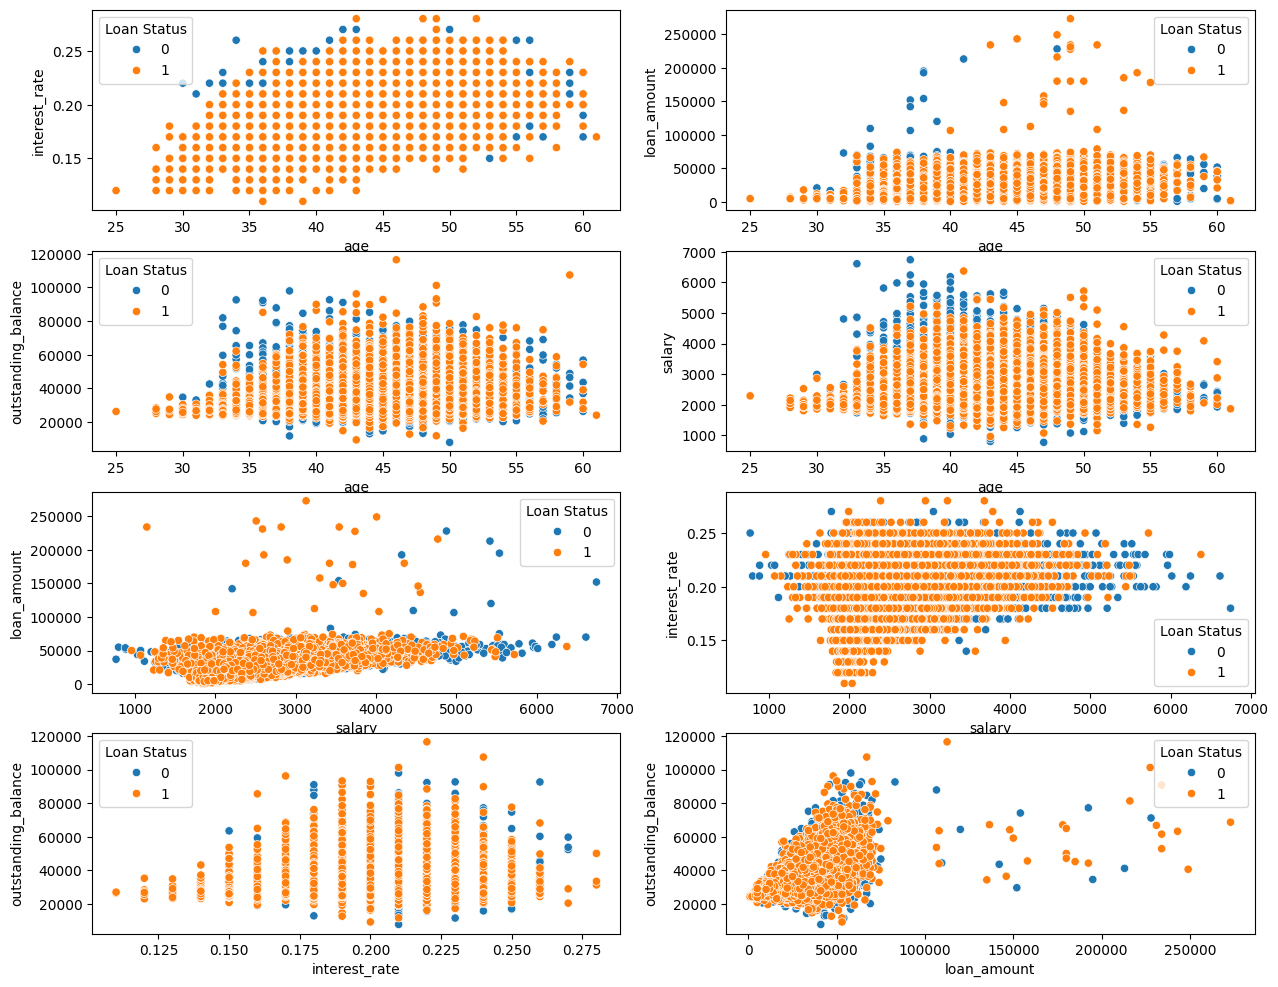

In [ ]:

plt.figure(figsize=(10, 6))
fig, ((ax, ax1), (ax2,ax3), (ax4, ax5),(ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize = (15,12))
sns.scatterplot(data=X_resampled, x='age', y= 'interest_rate', hue= y_resampled, ax= ax)
sns.scatterplot(data=X_resampled, x='age', y= 'loan_amount', hue= y_resampled, ax= ax1)
sns.scatterplot(data=X_resampled, x='age', y= 'outstanding_balance', hue= y_resampled, ax= ax2)
sns.scatterplot(data=X_resampled, x='age', y= 'salary', hue= y_resampled, ax= ax3)
sns.scatterplot(data=X_resampled, x='salary', y= 'loan_amount', hue= y_resampled, ax= ax4)
sns.scatterplot(data=X_resampled, x='salary', y= 'interest_rate', hue= y_resampled, ax= ax5)
sns.scatterplot(data=X_resampled, x='interest_rate', y= 'outstanding_balance', hue= y_resampled, ax= ax6)
sns.scatterplot(data=X_resampled, x='loan_amount', y= 'outstanding_balance', hue= y_resampled, ax= ax7)
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA

In [ ]:
# xgboost = xgb.XGBClassifier(
#                             max_depth = 8, 
#                             learning_rate = 0.20,
#                             n_estimators = 100,
                           
#                             )
# xgboost.fit(X_resampled, y_resampled)
# probas = xgboost.predict_proba(X_test)[:, 1]

# preds = (probas >= 0.2).astype(int)
# auc_score = roc_auc_score(y_test, preds)

# auc_score

X_test.columns, X_resampled.columns


(Index(['loan_amount', 'number_of_defaults', 'outstanding_balance',
        'interest_rate', 'age', 'remaining term', 'salary', 'low_risk',
        'marital_status_married', 'marital_status_single', 'gender_female',
        'gender_male', 'gender_other', 'job_Accountant', 'job_Data Analyst',
        'job_Data Scientist', 'job_Doctor', 'job_Engineer', 'job_Lawyer',
        'job_Nurse', 'job_Software Developer', 'job_Teacher',
        'location_Chipinge', 'location_Chiredzi', 'location_Gokwe',
        'location_Karoi', 'location_Kwekwe', 'location_Plumtree',
        'location_Redcliff', 'location_Shurugwi', 'location_Victoria Falls',
        'rate_age_ratio', 'K1', 'predicted_low_default'],
       dtype='object'),
 Index(['loan_amount', 'number_of_defaults', 'outstanding_balance',
        'interest_rate', 'age', 'remaining term', 'salary', 'low_risk',
        'marital_status_married', 'marital_status_single', 'gender_female',
        'gender_male', 'gender_other', 'job_Accountant', 'job_